# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -1.333063  0.598934  0.0  0.026414  1.422452  1.026876  3  1  23.737498   
1 -0.800791 -0.790296  0.0  0.086133  1.250488  1.715763  1  0  14.413150   
2  0.286431  1.518130  1.0  0.958333  1.109847  0.576780  2  0  34.920138   
3 -0.186018 -1.362402  1.0  0.626077  0.871265  2.608335  2  3  52.447525   
4 -1.337890  2.222374  1.0  0.417015  2.397741  1.724361  0  3  44.604711   

            y  
0  214.669228  
1   53.660111  
2  656.637463  
3  148.101725  
4  771.358644  
True causal estimate is 8.484513659533672


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

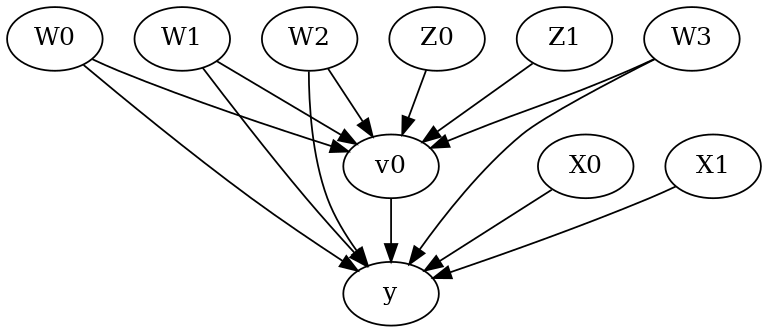

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W3,W2,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W2,W0,U) = P(y|v0,W1,W3,W2,W0)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W3,W2,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W2,W0,U) = P(y|v0,W1,W3,W2,W0)

## Realized estimand
b: y~v0+W1+W3+W2+W0+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 8.484217736596698
### Conditional Estimates
__categorical__X1              __categorical__X0
(-5.3020000000000005, -0.598]  (-4.618, -1.626]     -3.111808
                               (-1.626, -1.061]     -0.375608
                               (-1.061, -0.562]      1.177311
                               (-0.562, 0.033]       3.114023
                               (0.033, 2.902]        6.165696
(-0.598, -0.0153]              (-4.618, -1.626]      1.049642
                               (-1.626, -1.061]      4.041841
                               (-1.061,

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W3,W2,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W2,W0,U) = P(y|v0,W1,W3,W2,W0)

## Realized estimand
b: y~v0+W1+W3+W2+W0 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 15.371015790326293
Effect estimates: [16.03779134 19.76613044 17.04261569  8.56524562 17.25451651 10.04611603
 17.35771138  8.9868467  12.58665245 15.2356344  14.18504201  9.33011333
 14.38486166  8.28455318 10.25117219 17.95020256 20.67525769  8.26366502
 19.73151566 12.07110743 12.91431309 22.5433767  14.81344624 12.16500409
 18.50047875 12.42733546 13.17681329 27.7405839  21.5047366   3.34874124
 20.29666028 18.03295153 16.48278707 18.59322075 16.20018461 12.94457392
 13.07248626 20.81175317 19.11720261 16.82966147 25.66056961  9.9

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 8.484513659533672


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W3,W2,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W2,W0,U) = P(y|v0,W1,W3,W2,W0)

## Realized estimand
b: y~v0+W1+W3+W2+W0 | X1,X0
Target units: 

## Estimate
Mean value: 8.432780818321918
Effect estimates: [ 8.56513913  3.0912365  18.89014896 ...  6.3357338  15.69301592
 14.03409569]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W3,W2,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W2,W0,U) = P(y|v0,W1,W3,W2,W0)

## Realized estimand
b: y~v0+W1+W3+W2+W0 | X1,X0
Target units: ate

## Estimate
Mean value: 8.378519288951017
Effect estimates: [ 8.50641718  3.04025453 18.83846147 ...  6.28097941 15.6420728
 13.97302164]
95.0% confidence interval: (array([ 8.46047377,  2.80217223, 18.87060524, ...,  6.20990471,
       15.67283444, 13.93249523]), array([ 8.69955238,  3.1784187 , 19.53735631, ...,  6.40699646,
       16.15212829, 14.43550374]))



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[15.70237031 12.32714612 14.99653735 15.11966662 12.41468674 14.76462005
 13.96903244 11.6738003  16.33276147 13.66400387]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0     2.153157 -1.165068  0.0  0.869865 -0.122155 -0.241356 -0.664781   
1     1.512506 -0.099406  0.0  0.665059  1.910664 -2.090527 -1.012258   
2     2.438504 -0.328395  0.0  0.110724 -1.359944  0.369783 -0.999556   
3     0.851822 -2.163325  0.0  0.678152  1.040813 -1.243285 -0.935787   
4     1.293577 -0.677489  0.0  0.922203  1.523749 -2.587808  1.128561   
...        ...       ...  ...       ...       ...       ...       ...   
9995  2.721673 -1.032761  0.0  0.994322  1.502418 -0.249123 -1.439441   
9996  1.359288 -0.451367  0.0  0.575584  1.844833 -0.936572  0.453813   
9997  1.338955 -0.947549  0.0  0.942155  0.343202  0.743313  1.517475   
9998  1.734663  1.064395  0.0  0.262000  1.786063 -0.481329 -0.977780   
9999  2.628274 -0.368110  0.0  0.813593 -0.095612 -0.403194  2.136488   

            W3  v0  y  
0    -0.391116   1  1  
1     0.611584   1  1  
2     0.721215   0  0  
3    -0.752340   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W3,W2,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W2,W0,U) = P(y|v0,W1,W3,W2,W0)

## Realized estimand
b: y~v0+W1+W3+W2+W0 | X1,X0
Target units: ate

## Estimate
Mean value: 0.6992417248234339
Effect estimates: [0.73592538 0.70807244 0.73725446 ... 0.71012985 0.7047789  0.74317397]

True causal estimate is 0.5399


### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-11-15 09:08:21.445721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2022-11-15 09:08:21.743943: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-15 09:08:21.743979: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-15 09:08:21.777593: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2022-11-15 09:08:22.773389: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-15 09:08:22.773606: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-15 09:08:22.773625: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2022-11-15 09:08:24.000726: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-15 09:08:24.000774: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-15 09:08:24.000809: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (7b820a947e8d): /proc/driver/nvidia/version does not exist
2022-11-15 09:08:24.002430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 5:04 - loss: 352.1636

 23/313 [=>............................] - ETA: 0s - loss: 106.1795  

 48/313 [===>..........................] - ETA: 0s - loss: 55.9975 

 72/313 [=====>........................] - ETA: 0s - loss: 39.5507

 96/313 [========>.....................] - ETA: 0s - loss: 31.2217

122/313 [==========>...................] - ETA: 0s - loss: 25.8003

147/313 [=============>................] - ETA: 0s - loss: 22.3534

171/313 [===============>..............] - ETA: 0s - loss: 19.9934

194/313 [=================>............] - ETA: 0s - loss: 18.2243

218/313 [===================>..........] - ETA: 0s - loss: 16.7911

242/313 [======================>.......] - ETA: 0s - loss: 15.6193

265/313 [========================>.....] - ETA: 0s - loss: 14.6999

284/313 [==========================>...] - ETA: 0s - loss: 14.0491

309/313 [============================>.] - ETA: 0s - loss: 13.3019

313/313 [==============================] - 2s 2ms/step - loss: 13.1931


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 4.8239

 20/313 [>.............................] - ETA: 0s - loss: 4.8439

 42/313 [===>..........................] - ETA: 0s - loss: 4.8343

 62/313 [====>.........................] - ETA: 0s - loss: 4.8103

 84/313 [=======>......................] - ETA: 0s - loss: 4.7706

105/313 [=========>....................] - ETA: 0s - loss: 4.7500

129/313 [===========>..................] - ETA: 0s - loss: 4.7197

152/313 [=============>................] - ETA: 0s - loss: 4.7060

177/313 [===============>..............] - ETA: 0s - loss: 4.6877

201/313 [==================>...........] - ETA: 0s - loss: 4.6778

226/313 [====================>.........] - ETA: 0s - loss: 4.6608

250/313 [======================>.......] - ETA: 0s - loss: 4.6483

275/313 [=========================>....] - ETA: 0s - loss: 4.6315

301/313 [===========================>..] - ETA: 0s - loss: 4.6176

313/313 [==============================] - 1s 2ms/step - loss: 4.6127


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 4.3260

 25/313 [=>............................] - ETA: 0s - loss: 4.3529

 49/313 [===>..........................] - ETA: 0s - loss: 4.3827

 73/313 [=====>........................] - ETA: 0s - loss: 4.3851

 96/313 [========>.....................] - ETA: 0s - loss: 4.3845

118/313 [==========>...................] - ETA: 0s - loss: 4.3661

140/313 [============>.................] - ETA: 0s - loss: 4.3533

162/313 [==============>...............] - ETA: 0s - loss: 4.3407

185/313 [================>.............] - ETA: 0s - loss: 4.3392

209/313 [===================>..........] - ETA: 0s - loss: 4.3297

233/313 [=====================>........] - ETA: 0s - loss: 4.3256

258/313 [=======================>......] - ETA: 0s - loss: 4.3178

283/313 [==========================>...] - ETA: 0s - loss: 4.3043

306/313 [============================>.] - ETA: 0s - loss: 4.2948

313/313 [==============================] - 1s 2ms/step - loss: 4.2929


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 4.0846

 25/313 [=>............................] - ETA: 0s - loss: 4.1358

 49/313 [===>..........................] - ETA: 0s - loss: 4.1515

 71/313 [=====>........................] - ETA: 0s - loss: 4.1265

 96/313 [========>.....................] - ETA: 0s - loss: 4.1397

121/313 [==========>...................] - ETA: 0s - loss: 4.1286

147/313 [=============>................] - ETA: 0s - loss: 4.1204

171/313 [===============>..............] - ETA: 0s - loss: 4.1078

195/313 [=================>............] - ETA: 0s - loss: 4.0950

220/313 [====================>.........] - ETA: 0s - loss: 4.0904

246/313 [======================>.......] - ETA: 0s - loss: 4.0783

268/313 [========================>.....] - ETA: 0s - loss: 4.0706

291/313 [==========================>...] - ETA: 0s - loss: 4.0622

313/313 [==============================] - ETA: 0s - loss: 4.0470

313/313 [==============================] - 1s 2ms/step - loss: 4.0470


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 3.6926

 25/313 [=>............................] - ETA: 0s - loss: 3.8620

 48/313 [===>..........................] - ETA: 0s - loss: 3.8284

 73/313 [=====>........................] - ETA: 0s - loss: 3.8113

 96/313 [========>.....................] - ETA: 0s - loss: 3.7774

121/313 [==========>...................] - ETA: 0s - loss: 3.7627

144/313 [============>.................] - ETA: 0s - loss: 3.7255

168/313 [===============>..............] - ETA: 0s - loss: 3.6851

191/313 [=================>............] - ETA: 0s - loss: 3.6451

216/313 [===================>..........] - ETA: 0s - loss: 3.6074

241/313 [======================>.......] - ETA: 0s - loss: 3.5754

266/313 [========================>.....] - ETA: 0s - loss: 3.5424

290/313 [==========================>...] - ETA: 0s - loss: 3.5145

313/313 [==============================] - ETA: 0s - loss: 3.4918

313/313 [==============================] - 1s 2ms/step - loss: 3.4918


Epoch 6/25


  1/313 [..............................] - ETA: 2s - loss: 3.0677

 23/313 [=>............................] - ETA: 0s - loss: 3.1931

 42/313 [===>..........................] - ETA: 0s - loss: 3.1944

 64/313 [=====>........................] - ETA: 0s - loss: 3.2051

 84/313 [=======>......................] - ETA: 0s - loss: 3.1971

108/313 [=========>....................] - ETA: 0s - loss: 3.1997

128/313 [===========>..................] - ETA: 0s - loss: 3.2013

152/313 [=============>................] - ETA: 0s - loss: 3.1852

177/313 [===============>..............] - ETA: 0s - loss: 3.1782

200/313 [==================>...........] - ETA: 0s - loss: 3.1707

219/313 [===================>..........] - ETA: 0s - loss: 3.1670

241/313 [======================>.......] - ETA: 0s - loss: 3.1535

262/313 [========================>.....] - ETA: 0s - loss: 3.1480

285/313 [==========================>...] - ETA: 0s - loss: 3.1456

308/313 [============================>.] - ETA: 0s - loss: 3.1399

313/313 [==============================] - 1s 2ms/step - loss: 3.1388


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 3.0815

 27/313 [=>............................] - ETA: 0s - loss: 3.0893

 50/313 [===>..........................] - ETA: 0s - loss: 3.0982

 73/313 [=====>........................] - ETA: 0s - loss: 3.1014

 97/313 [========>.....................] - ETA: 0s - loss: 3.0983

120/313 [==========>...................] - ETA: 0s - loss: 3.0881

144/313 [============>.................] - ETA: 0s - loss: 3.0822

168/313 [===============>..............] - ETA: 0s - loss: 3.0718

191/313 [=================>............] - ETA: 0s - loss: 3.0703

214/313 [===================>..........] - ETA: 0s - loss: 3.0678

238/313 [=====================>........] - ETA: 0s - loss: 3.0619

259/313 [=======================>......] - ETA: 0s - loss: 3.0626

280/313 [=========================>....] - ETA: 0s - loss: 3.0656

296/313 [===========================>..] - ETA: 0s - loss: 3.0599

312/313 [============================>.] - ETA: 0s - loss: 3.0621

313/313 [==============================] - 1s 2ms/step - loss: 3.0609


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 2.9434

 18/313 [>.............................] - ETA: 0s - loss: 3.0699

 42/313 [===>..........................] - ETA: 0s - loss: 3.0455

 65/313 [=====>........................] - ETA: 0s - loss: 3.0585

 89/313 [=======>......................] - ETA: 0s - loss: 3.0590

112/313 [=========>....................] - ETA: 0s - loss: 3.0624

135/313 [===========>..................] - ETA: 0s - loss: 3.0594

158/313 [==============>...............] - ETA: 0s - loss: 3.0599

183/313 [================>.............] - ETA: 0s - loss: 3.0514

207/313 [==================>...........] - ETA: 0s - loss: 3.0492

232/313 [=====================>........] - ETA: 0s - loss: 3.0483

256/313 [=======================>......] - ETA: 0s - loss: 3.0513

279/313 [=========================>....] - ETA: 0s - loss: 3.0493

303/313 [============================>.] - ETA: 0s - loss: 3.0425

313/313 [==============================] - 1s 2ms/step - loss: 3.0392


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 3.3098

 25/313 [=>............................] - ETA: 0s - loss: 3.0325

 46/313 [===>..........................] - ETA: 0s - loss: 3.0203

 69/313 [=====>........................] - ETA: 0s - loss: 3.0428

 94/313 [========>.....................] - ETA: 0s - loss: 3.0414

119/313 [==========>...................] - ETA: 0s - loss: 3.0368

144/313 [============>.................] - ETA: 0s - loss: 3.0385

168/313 [===============>..............] - ETA: 0s - loss: 3.0410

192/313 [=================>............] - ETA: 0s - loss: 3.0378

217/313 [===================>..........] - ETA: 0s - loss: 3.0413

242/313 [======================>.......] - ETA: 0s - loss: 3.0379

267/313 [========================>.....] - ETA: 0s - loss: 3.0399

292/313 [==========================>...] - ETA: 0s - loss: 3.0376

313/313 [==============================] - 1s 2ms/step - loss: 3.0353


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 2.9700

 25/313 [=>............................] - ETA: 0s - loss: 3.0089

 48/313 [===>..........................] - ETA: 0s - loss: 2.9862

 69/313 [=====>........................] - ETA: 0s - loss: 2.9681

 94/313 [========>.....................] - ETA: 0s - loss: 2.9815

118/313 [==========>...................] - ETA: 0s - loss: 2.9792

142/313 [============>.................] - ETA: 0s - loss: 2.9780

163/313 [==============>...............] - ETA: 0s - loss: 2.9833

179/313 [================>.............] - ETA: 0s - loss: 2.9892

201/313 [==================>...........] - ETA: 0s - loss: 2.9894

221/313 [====================>.........] - ETA: 0s - loss: 2.9870

242/313 [======================>.......] - ETA: 0s - loss: 2.9865

265/313 [========================>.....] - ETA: 0s - loss: 2.9830

288/313 [==========================>...] - ETA: 0s - loss: 2.9839

311/313 [============================>.] - ETA: 0s - loss: 2.9849

313/313 [==============================] - 1s 2ms/step - loss: 2.9842


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 2.9888

 23/313 [=>............................] - ETA: 0s - loss: 2.9769

 46/313 [===>..........................] - ETA: 0s - loss: 2.9496

 69/313 [=====>........................] - ETA: 0s - loss: 2.9620

 93/313 [=======>......................] - ETA: 0s - loss: 2.9612

117/313 [==========>...................] - ETA: 0s - loss: 2.9623

142/313 [============>.................] - ETA: 0s - loss: 2.9587

165/313 [==============>...............] - ETA: 0s - loss: 2.9487

190/313 [=================>............] - ETA: 0s - loss: 2.9474

215/313 [===================>..........] - ETA: 0s - loss: 2.9470

239/313 [=====================>........] - ETA: 0s - loss: 2.9510

264/313 [========================>.....] - ETA: 0s - loss: 2.9523

287/313 [==========================>...] - ETA: 0s - loss: 2.9536

308/313 [============================>.] - ETA: 0s - loss: 2.9493

313/313 [==============================] - 1s 2ms/step - loss: 2.9511


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 2.7824

 24/313 [=>............................] - ETA: 0s - loss: 2.9566

 46/313 [===>..........................] - ETA: 0s - loss: 2.9478

 69/313 [=====>........................] - ETA: 0s - loss: 2.9371

 93/313 [=======>......................] - ETA: 0s - loss: 2.9331

112/313 [=========>....................] - ETA: 0s - loss: 2.9249

134/313 [===========>..................] - ETA: 0s - loss: 2.9242

159/313 [==============>...............] - ETA: 0s - loss: 2.9252

184/313 [================>.............] - ETA: 0s - loss: 2.9250

206/313 [==================>...........] - ETA: 0s - loss: 2.9312

230/313 [=====================>........] - ETA: 0s - loss: 2.9335

255/313 [=======================>......] - ETA: 0s - loss: 2.9344

280/313 [=========================>....] - ETA: 0s - loss: 2.9334

305/313 [============================>.] - ETA: 0s - loss: 2.9325

313/313 [==============================] - 1s 2ms/step - loss: 2.9318


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 2.8988

 20/313 [>.............................] - ETA: 0s - loss: 2.9222

 45/313 [===>..........................] - ETA: 0s - loss: 2.8964

 70/313 [=====>........................] - ETA: 0s - loss: 2.9072

 92/313 [=======>......................] - ETA: 0s - loss: 2.9125

112/313 [=========>....................] - ETA: 0s - loss: 2.9109

134/313 [===========>..................] - ETA: 0s - loss: 2.9071

158/313 [==============>...............] - ETA: 0s - loss: 2.9085

182/313 [================>.............] - ETA: 0s - loss: 2.9163

207/313 [==================>...........] - ETA: 0s - loss: 2.9187

231/313 [=====================>........] - ETA: 0s - loss: 2.9148

250/313 [======================>.......] - ETA: 0s - loss: 2.9099

274/313 [=========================>....] - ETA: 0s - loss: 2.9089

297/313 [===========================>..] - ETA: 0s - loss: 2.9060

313/313 [==============================] - 1s 2ms/step - loss: 2.9050


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 2.9001

 26/313 [=>............................] - ETA: 0s - loss: 2.9338

 52/313 [===>..........................] - ETA: 0s - loss: 2.9182

 74/313 [======>.......................] - ETA: 0s - loss: 2.9136

 98/313 [========>.....................] - ETA: 0s - loss: 2.8940

123/313 [==========>...................] - ETA: 0s - loss: 2.8955

148/313 [=============>................] - ETA: 0s - loss: 2.8917

175/313 [===============>..............] - ETA: 0s - loss: 2.8967

197/313 [=================>............] - ETA: 0s - loss: 2.8915

222/313 [====================>.........] - ETA: 0s - loss: 2.8905

246/313 [======================>.......] - ETA: 0s - loss: 2.8924

269/313 [========================>.....] - ETA: 0s - loss: 2.8909

293/313 [===========================>..] - ETA: 0s - loss: 2.8949

313/313 [==============================] - 1s 2ms/step - loss: 2.8951


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 2.7279

 25/313 [=>............................] - ETA: 0s - loss: 2.8703

 49/313 [===>..........................] - ETA: 0s - loss: 2.8621

 74/313 [======>.......................] - ETA: 0s - loss: 2.8712

 99/313 [========>.....................] - ETA: 0s - loss: 2.8707

124/313 [==========>...................] - ETA: 0s - loss: 2.8874

146/313 [============>.................] - ETA: 0s - loss: 2.8825

170/313 [===============>..............] - ETA: 0s - loss: 2.8767

195/313 [=================>............] - ETA: 0s - loss: 2.8749

220/313 [====================>.........] - ETA: 0s - loss: 2.8771

245/313 [======================>.......] - ETA: 0s - loss: 2.8735

270/313 [========================>.....] - ETA: 0s - loss: 2.8736

295/313 [===========================>..] - ETA: 0s - loss: 2.8662

313/313 [==============================] - 1s 2ms/step - loss: 2.8644


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 2.6145

 22/313 [=>............................] - ETA: 0s - loss: 2.8449

 46/313 [===>..........................] - ETA: 0s - loss: 2.8527

 70/313 [=====>........................] - ETA: 0s - loss: 2.8400

 93/313 [=======>......................] - ETA: 0s - loss: 2.8442

117/313 [==========>...................] - ETA: 0s - loss: 2.8338

141/313 [============>.................] - ETA: 0s - loss: 2.8406

163/313 [==============>...............] - ETA: 0s - loss: 2.8355

188/313 [=================>............] - ETA: 0s - loss: 2.8406

212/313 [===================>..........] - ETA: 0s - loss: 2.8384

236/313 [=====================>........] - ETA: 0s - loss: 2.8383

260/313 [=======================>......] - ETA: 0s - loss: 2.8422

283/313 [==========================>...] - ETA: 0s - loss: 2.8358

306/313 [============================>.] - ETA: 0s - loss: 2.8370

313/313 [==============================] - 1s 2ms/step - loss: 2.8345


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 2.8050

 27/313 [=>............................] - ETA: 0s - loss: 2.8430

 51/313 [===>..........................] - ETA: 0s - loss: 2.8380

 76/313 [======>.......................] - ETA: 0s - loss: 2.8279

100/313 [========>.....................] - ETA: 0s - loss: 2.8281

124/313 [==========>...................] - ETA: 0s - loss: 2.8358

149/313 [=============>................] - ETA: 0s - loss: 2.8321

171/313 [===============>..............] - ETA: 0s - loss: 2.8331

191/313 [=================>............] - ETA: 0s - loss: 2.8291

211/313 [===================>..........] - ETA: 0s - loss: 2.8252

236/313 [=====================>........] - ETA: 0s - loss: 2.8264

258/313 [=======================>......] - ETA: 0s - loss: 2.8258

283/313 [==========================>...] - ETA: 0s - loss: 2.8219

306/313 [============================>.] - ETA: 0s - loss: 2.8200

313/313 [==============================] - 1s 2ms/step - loss: 2.8190


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 2.8681

 26/313 [=>............................] - ETA: 0s - loss: 2.8479

 48/313 [===>..........................] - ETA: 0s - loss: 2.8349

 71/313 [=====>........................] - ETA: 0s - loss: 2.8105

 94/313 [========>.....................] - ETA: 0s - loss: 2.8082

119/313 [==========>...................] - ETA: 0s - loss: 2.8016

139/313 [============>.................] - ETA: 0s - loss: 2.8056

161/313 [==============>...............] - ETA: 0s - loss: 2.8068

183/313 [================>.............] - ETA: 0s - loss: 2.8089

208/313 [==================>...........] - ETA: 0s - loss: 2.8115

232/313 [=====================>........] - ETA: 0s - loss: 2.8109

257/313 [=======================>......] - ETA: 0s - loss: 2.8128

281/313 [=========================>....] - ETA: 0s - loss: 2.8115

304/313 [============================>.] - ETA: 0s - loss: 2.8107

313/313 [==============================] - 1s 2ms/step - loss: 2.8111


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 2.8180

 24/313 [=>............................] - ETA: 0s - loss: 2.8218

 48/313 [===>..........................] - ETA: 0s - loss: 2.8057

 70/313 [=====>........................] - ETA: 0s - loss: 2.8079

 87/313 [=======>......................] - ETA: 0s - loss: 2.8049

111/313 [=========>....................] - ETA: 0s - loss: 2.8079

134/313 [===========>..................] - ETA: 0s - loss: 2.7999

154/313 [=============>................] - ETA: 0s - loss: 2.8060

178/313 [================>.............] - ETA: 0s - loss: 2.8095

201/313 [==================>...........] - ETA: 0s - loss: 2.8056

226/313 [====================>.........] - ETA: 0s - loss: 2.7952

252/313 [=======================>......] - ETA: 0s - loss: 2.7918

277/313 [=========================>....] - ETA: 0s - loss: 2.7928

302/313 [===========================>..] - ETA: 0s - loss: 2.7907

313/313 [==============================] - 1s 2ms/step - loss: 2.7910


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 2.6784

 25/313 [=>............................] - ETA: 0s - loss: 2.7563

 45/313 [===>..........................] - ETA: 0s - loss: 2.7880

 69/313 [=====>........................] - ETA: 0s - loss: 2.7977

 93/313 [=======>......................] - ETA: 0s - loss: 2.7907

117/313 [==========>...................] - ETA: 0s - loss: 2.7888

139/313 [============>.................] - ETA: 0s - loss: 2.7989

159/313 [==============>...............] - ETA: 0s - loss: 2.7908

183/313 [================>.............] - ETA: 0s - loss: 2.7931

205/313 [==================>...........] - ETA: 0s - loss: 2.7943

227/313 [====================>.........] - ETA: 0s - loss: 2.7947

247/313 [======================>.......] - ETA: 0s - loss: 2.7944

268/313 [========================>.....] - ETA: 0s - loss: 2.7946

290/313 [==========================>...] - ETA: 0s - loss: 2.7932

313/313 [==============================] - ETA: 0s - loss: 2.7918

313/313 [==============================] - 1s 2ms/step - loss: 2.7918


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 2.8596

 25/313 [=>............................] - ETA: 0s - loss: 2.7956

 49/313 [===>..........................] - ETA: 0s - loss: 2.7929

 73/313 [=====>........................] - ETA: 0s - loss: 2.7736

 92/313 [=======>......................] - ETA: 0s - loss: 2.7753

108/313 [=========>....................] - ETA: 0s - loss: 2.7780

133/313 [===========>..................] - ETA: 0s - loss: 2.7800

158/313 [==============>...............] - ETA: 0s - loss: 2.7815

183/313 [================>.............] - ETA: 0s - loss: 2.7822

208/313 [==================>...........] - ETA: 0s - loss: 2.7816

233/313 [=====================>........] - ETA: 0s - loss: 2.7764

257/313 [=======================>......] - ETA: 0s - loss: 2.7745

277/313 [=========================>....] - ETA: 0s - loss: 2.7761

300/313 [===========================>..] - ETA: 0s - loss: 2.7759

313/313 [==============================] - 1s 2ms/step - loss: 2.7763


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 3.0800

 25/313 [=>............................] - ETA: 0s - loss: 2.7775

 47/313 [===>..........................] - ETA: 0s - loss: 2.7810

 71/313 [=====>........................] - ETA: 0s - loss: 2.7664

 96/313 [========>.....................] - ETA: 0s - loss: 2.7736

120/313 [==========>...................] - ETA: 0s - loss: 2.7719

145/313 [============>.................] - ETA: 0s - loss: 2.7653

168/313 [===============>..............] - ETA: 0s - loss: 2.7716

193/313 [=================>............] - ETA: 0s - loss: 2.7706

212/313 [===================>..........] - ETA: 0s - loss: 2.7698

231/313 [=====================>........] - ETA: 0s - loss: 2.7728

254/313 [=======================>......] - ETA: 0s - loss: 2.7737

278/313 [=========================>....] - ETA: 0s - loss: 2.7774

301/313 [===========================>..] - ETA: 0s - loss: 2.7815

313/313 [==============================] - 1s 2ms/step - loss: 2.7804


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 2.8634

 26/313 [=>............................] - ETA: 0s - loss: 2.7780

 49/313 [===>..........................] - ETA: 0s - loss: 2.7728

 73/313 [=====>........................] - ETA: 0s - loss: 2.7593

 95/313 [========>.....................] - ETA: 0s - loss: 2.7636

111/313 [=========>....................] - ETA: 0s - loss: 2.7647

134/313 [===========>..................] - ETA: 0s - loss: 2.7699

158/313 [==============>...............] - ETA: 0s - loss: 2.7772

181/313 [================>.............] - ETA: 0s - loss: 2.7761

206/313 [==================>...........] - ETA: 0s - loss: 2.7776

230/313 [=====================>........] - ETA: 0s - loss: 2.7754

254/313 [=======================>......] - ETA: 0s - loss: 2.7762

279/313 [=========================>....] - ETA: 0s - loss: 2.7744

301/313 [===========================>..] - ETA: 0s - loss: 2.7748

313/313 [==============================] - 1s 2ms/step - loss: 2.7723


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 2.6621

 24/313 [=>............................] - ETA: 0s - loss: 2.7787

 49/313 [===>..........................] - ETA: 0s - loss: 2.7616

 73/313 [=====>........................] - ETA: 0s - loss: 2.7450

 98/313 [========>.....................] - ETA: 0s - loss: 2.7565

122/313 [==========>...................] - ETA: 0s - loss: 2.7564

147/313 [=============>................] - ETA: 0s - loss: 2.7611

171/313 [===============>..............] - ETA: 0s - loss: 2.7561

195/313 [=================>............] - ETA: 0s - loss: 2.7554

219/313 [===================>..........] - ETA: 0s - loss: 2.7542

243/313 [======================>.......] - ETA: 0s - loss: 2.7578

266/313 [========================>.....] - ETA: 0s - loss: 2.7564

290/313 [==========================>...] - ETA: 0s - loss: 2.7571

313/313 [==============================] - 1s 2ms/step - loss: 2.7580


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 2.6632

 26/313 [=>............................] - ETA: 0s - loss: 2.7608

 51/313 [===>..........................] - ETA: 0s - loss: 2.7551

 75/313 [======>.......................] - ETA: 0s - loss: 2.7595

 98/313 [========>.....................] - ETA: 0s - loss: 2.7647

121/313 [==========>...................] - ETA: 0s - loss: 2.7623

145/313 [============>.................] - ETA: 0s - loss: 2.7647

163/313 [==============>...............] - ETA: 0s - loss: 2.7605

188/313 [=================>............] - ETA: 0s - loss: 2.7599

213/313 [===================>..........] - ETA: 0s - loss: 2.7574

238/313 [=====================>........] - ETA: 0s - loss: 2.7576

263/313 [========================>.....] - ETA: 0s - loss: 2.7578

288/313 [==========================>...] - ETA: 0s - loss: 2.7571

312/313 [============================>.] - ETA: 0s - loss: 2.7573

313/313 [==============================] - 1s 2ms/step - loss: 2.7576


Epoch 1/25


  1/313 [..............................] - ETA: 5:55 - loss: 114037.7969

 19/313 [>.............................] - ETA: 0s - loss: 104790.8359  

 38/313 [==>...........................] - ETA: 0s - loss: 104266.1875

 57/313 [====>.........................] - ETA: 0s - loss: 96280.2344 

 75/313 [======>.......................] - ETA: 0s - loss: 84496.9609

 94/313 [========>.....................] - ETA: 0s - loss: 77718.1641

114/313 [=========>....................] - ETA: 0s - loss: 73565.5781

133/313 [===========>..................] - ETA: 0s - loss: 71125.2969

151/313 [=============>................] - ETA: 0s - loss: 68284.2344

171/313 [===============>..............] - ETA: 0s - loss: 65752.5312

190/313 [=================>............] - ETA: 0s - loss: 63962.2852

209/313 [===================>..........] - ETA: 0s - loss: 61735.1055

229/313 [====================>.........] - ETA: 0s - loss: 59648.9336

250/313 [======================>.......] - ETA: 0s - loss: 57747.7148

270/313 [========================>.....] - ETA: 0s - loss: 56266.9531

288/313 [==========================>...] - ETA: 0s - loss: 54949.2617

307/313 [============================>.] - ETA: 0s - loss: 54522.6484

313/313 [==============================] - 2s 3ms/step - loss: 53933.9102


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 36812.8516

 19/313 [>.............................] - ETA: 0s - loss: 28257.1016

 34/313 [==>...........................] - ETA: 0s - loss: 26701.1074

 52/313 [===>..........................] - ETA: 0s - loss: 25487.9141

 69/313 [=====>........................] - ETA: 0s - loss: 24889.0762

 89/313 [=======>......................] - ETA: 0s - loss: 24022.8535

108/313 [=========>....................] - ETA: 0s - loss: 23591.8574

128/313 [===========>..................] - ETA: 0s - loss: 23215.9043

147/313 [=============>................] - ETA: 0s - loss: 22533.4277

167/313 [===============>..............] - ETA: 0s - loss: 22036.3945

186/313 [================>.............] - ETA: 0s - loss: 21774.7148

203/313 [==================>...........] - ETA: 0s - loss: 21480.7207

224/313 [====================>.........] - ETA: 0s - loss: 21416.2910

245/313 [======================>.......] - ETA: 0s - loss: 21088.2988

264/313 [========================>.....] - ETA: 0s - loss: 20972.0840

285/313 [==========================>...] - ETA: 0s - loss: 20562.9121

305/313 [============================>.] - ETA: 0s - loss: 20304.6523

313/313 [==============================] - 1s 3ms/step - loss: 20324.4473


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 12059.4805

 22/313 [=>............................] - ETA: 0s - loss: 18120.8438

 42/313 [===>..........................] - ETA: 0s - loss: 19069.2109

 62/313 [====>.........................] - ETA: 0s - loss: 18670.0215

 83/313 [======>.......................] - ETA: 0s - loss: 18208.2363

103/313 [========>.....................] - ETA: 0s - loss: 18076.4219

120/313 [==========>...................] - ETA: 0s - loss: 18244.9258

141/313 [============>.................] - ETA: 0s - loss: 18376.1289

159/313 [==============>...............] - ETA: 0s - loss: 18044.9023

179/313 [================>.............] - ETA: 0s - loss: 17868.9141

199/313 [==================>...........] - ETA: 0s - loss: 17636.5508

219/313 [===================>..........] - ETA: 0s - loss: 17391.7578

239/313 [=====================>........] - ETA: 0s - loss: 17267.2402

257/313 [=======================>......] - ETA: 0s - loss: 17372.6270

277/313 [=========================>....] - ETA: 0s - loss: 17480.9160

298/313 [===========================>..] - ETA: 0s - loss: 17327.2930

313/313 [==============================] - 1s 3ms/step - loss: 17366.6602


Epoch 4/25


  1/313 [..............................] - ETA: 2s - loss: 9992.4160

 21/313 [=>............................] - ETA: 0s - loss: 15612.9541

 41/313 [==>...........................] - ETA: 0s - loss: 16684.9180

 61/313 [====>.........................] - ETA: 0s - loss: 16556.0918

 81/313 [======>.......................] - ETA: 0s - loss: 16681.3281

 99/313 [========>.....................] - ETA: 0s - loss: 16680.6074

117/313 [==========>...................] - ETA: 0s - loss: 16376.1699

130/313 [===========>..................] - ETA: 0s - loss: 16726.1621

145/313 [============>.................] - ETA: 0s - loss: 16493.9160

161/313 [==============>...............] - ETA: 0s - loss: 16231.4658

179/313 [================>.............] - ETA: 0s - loss: 16325.0420

194/313 [=================>............] - ETA: 0s - loss: 16214.9854

211/313 [===================>..........] - ETA: 0s - loss: 15916.0342

231/313 [=====================>........] - ETA: 0s - loss: 15844.3682

251/313 [=======================>......] - ETA: 0s - loss: 15992.5176

269/313 [========================>.....] - ETA: 0s - loss: 15927.8291

289/313 [==========================>...] - ETA: 0s - loss: 15852.5137

309/313 [============================>.] - ETA: 0s - loss: 15885.3945

313/313 [==============================] - 1s 3ms/step - loss: 15859.5078


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 15397.5840

 22/313 [=>............................] - ETA: 0s - loss: 16051.8779

 40/313 [==>...........................] - ETA: 0s - loss: 15852.5312

 59/313 [====>.........................] - ETA: 0s - loss: 16039.7344

 81/313 [======>.......................] - ETA: 0s - loss: 16188.7607

101/313 [========>.....................] - ETA: 0s - loss: 15583.5459

119/313 [==========>...................] - ETA: 0s - loss: 15380.8564

139/313 [============>.................] - ETA: 0s - loss: 15456.4170

159/313 [==============>...............] - ETA: 0s - loss: 15371.1475

177/313 [===============>..............] - ETA: 0s - loss: 15261.6572

195/313 [=================>............] - ETA: 0s - loss: 15296.3496

215/313 [===================>..........] - ETA: 0s - loss: 15261.2988

234/313 [=====================>........] - ETA: 0s - loss: 15371.9922

256/313 [=======================>......] - ETA: 0s - loss: 15326.9180

276/313 [=========================>....] - ETA: 0s - loss: 15422.1357

296/313 [===========================>..] - ETA: 0s - loss: 15269.7412

313/313 [==============================] - 1s 3ms/step - loss: 15299.7334


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 10133.8662

 22/313 [=>............................] - ETA: 0s - loss: 13973.7070

 43/313 [===>..........................] - ETA: 0s - loss: 13800.3213

 63/313 [=====>........................] - ETA: 0s - loss: 14152.0508

 84/313 [=======>......................] - ETA: 0s - loss: 14658.9570

104/313 [========>.....................] - ETA: 0s - loss: 14698.6396

123/313 [==========>...................] - ETA: 0s - loss: 14952.7861

143/313 [============>.................] - ETA: 0s - loss: 15008.2100

162/313 [==============>...............] - ETA: 0s - loss: 15118.0215

180/313 [================>.............] - ETA: 0s - loss: 15097.2695

200/313 [==================>...........] - ETA: 0s - loss: 15000.0312

218/313 [===================>..........] - ETA: 0s - loss: 15075.4795

239/313 [=====================>........] - ETA: 0s - loss: 15080.8564

259/313 [=======================>......] - ETA: 0s - loss: 15081.0430

279/313 [=========================>....] - ETA: 0s - loss: 14965.6670

300/313 [===========================>..] - ETA: 0s - loss: 14932.0850

313/313 [==============================] - 1s 3ms/step - loss: 14980.7441


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 8546.6426

 20/313 [>.............................] - ETA: 0s - loss: 15194.1035

 39/313 [==>...........................] - ETA: 0s - loss: 15136.9707

 58/313 [====>.........................] - ETA: 0s - loss: 14903.2490

 79/313 [======>.......................] - ETA: 0s - loss: 15144.6201

 99/313 [========>.....................] - ETA: 0s - loss: 14938.6152

118/313 [==========>...................] - ETA: 0s - loss: 15253.4121

137/313 [============>.................] - ETA: 0s - loss: 15380.3545

157/313 [==============>...............] - ETA: 0s - loss: 15246.5029

175/313 [===============>..............] - ETA: 0s - loss: 15119.8916

193/313 [=================>............] - ETA: 0s - loss: 15177.8584

212/313 [===================>..........] - ETA: 0s - loss: 15248.2256

229/313 [====================>.........] - ETA: 0s - loss: 15187.8096

246/313 [======================>.......] - ETA: 0s - loss: 15075.1807

264/313 [========================>.....] - ETA: 0s - loss: 15052.1318

283/313 [==========================>...] - ETA: 0s - loss: 15043.9414

303/313 [============================>.] - ETA: 0s - loss: 15131.4189

313/313 [==============================] - 1s 3ms/step - loss: 15145.6426


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 14614.0332

 19/313 [>.............................] - ETA: 0s - loss: 14491.7627

 35/313 [==>...........................] - ETA: 0s - loss: 14073.0215

 54/313 [====>.........................] - ETA: 0s - loss: 14545.2109

 72/313 [=====>........................] - ETA: 0s - loss: 14609.1602

 86/313 [=======>......................] - ETA: 0s - loss: 14316.3223

104/313 [========>.....................] - ETA: 0s - loss: 14582.1270

123/313 [==========>...................] - ETA: 0s - loss: 14823.5205

140/313 [============>.................] - ETA: 0s - loss: 14625.4990

159/313 [==============>...............] - ETA: 0s - loss: 14646.4980

178/313 [================>.............] - ETA: 0s - loss: 14653.1738

196/313 [=================>............] - ETA: 0s - loss: 14715.0879

216/313 [===================>..........] - ETA: 0s - loss: 14812.7422

236/313 [=====================>........] - ETA: 0s - loss: 14817.1055

256/313 [=======================>......] - ETA: 0s - loss: 14888.8398

276/313 [=========================>....] - ETA: 0s - loss: 14897.0596

293/313 [===========================>..] - ETA: 0s - loss: 14880.3945

312/313 [============================>.] - ETA: 0s - loss: 14856.5703

313/313 [==============================] - 1s 3ms/step - loss: 14833.1816


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 10132.1768

 21/313 [=>............................] - ETA: 0s - loss: 15365.1650

 41/313 [==>...........................] - ETA: 0s - loss: 15412.3311

 59/313 [====>.........................] - ETA: 0s - loss: 15127.8984

 78/313 [======>.......................] - ETA: 0s - loss: 15258.5127

 99/313 [========>.....................] - ETA: 0s - loss: 15339.9961

116/313 [==========>...................] - ETA: 0s - loss: 15206.4209

134/313 [===========>..................] - ETA: 0s - loss: 14947.0830

151/313 [=============>................] - ETA: 0s - loss: 14853.0186

171/313 [===============>..............] - ETA: 0s - loss: 14843.7490

193/313 [=================>............] - ETA: 0s - loss: 14782.7744

214/313 [===================>..........] - ETA: 0s - loss: 14810.2881

235/313 [=====================>........] - ETA: 0s - loss: 14795.7656

256/313 [=======================>......] - ETA: 0s - loss: 14866.9932

276/313 [=========================>....] - ETA: 0s - loss: 14748.0703

293/313 [===========================>..] - ETA: 0s - loss: 14877.8330

313/313 [==============================] - ETA: 0s - loss: 14716.6162

313/313 [==============================] - 1s 3ms/step - loss: 14716.6162


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 14802.3320

 22/313 [=>............................] - ETA: 0s - loss: 15390.6445

 42/313 [===>..........................] - ETA: 0s - loss: 15681.1543

 62/313 [====>.........................] - ETA: 0s - loss: 15220.0625

 83/313 [======>.......................] - ETA: 0s - loss: 14667.4814

103/313 [========>.....................] - ETA: 0s - loss: 14970.0234

121/313 [==========>...................] - ETA: 0s - loss: 15000.8779

141/313 [============>.................] - ETA: 0s - loss: 14770.8311

162/313 [==============>...............] - ETA: 0s - loss: 14894.2227

183/313 [================>.............] - ETA: 0s - loss: 14782.0791

202/313 [==================>...........] - ETA: 0s - loss: 14725.0645

223/313 [====================>.........] - ETA: 0s - loss: 14572.2529

244/313 [======================>.......] - ETA: 0s - loss: 14558.2686

264/313 [========================>.....] - ETA: 0s - loss: 14643.1455

284/313 [==========================>...] - ETA: 0s - loss: 14766.0400

305/313 [============================>.] - ETA: 0s - loss: 14832.3906

313/313 [==============================] - 1s 3ms/step - loss: 14872.7783


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 13202.0117

 22/313 [=>............................] - ETA: 0s - loss: 14604.4971

 42/313 [===>..........................] - ETA: 0s - loss: 14897.0234

 62/313 [====>.........................] - ETA: 0s - loss: 14711.4287

 83/313 [======>.......................] - ETA: 0s - loss: 14677.5312

102/313 [========>.....................] - ETA: 0s - loss: 14713.2656

121/313 [==========>...................] - ETA: 0s - loss: 14561.1172

141/313 [============>.................] - ETA: 0s - loss: 14575.3975

161/313 [==============>...............] - ETA: 0s - loss: 14629.1680

181/313 [================>.............] - ETA: 0s - loss: 14821.6045

201/313 [==================>...........] - ETA: 0s - loss: 14835.2861

221/313 [====================>.........] - ETA: 0s - loss: 14943.7852

240/313 [======================>.......] - ETA: 0s - loss: 14934.0791

261/313 [========================>.....] - ETA: 0s - loss: 14911.7793

281/313 [=========================>....] - ETA: 0s - loss: 14797.9922

302/313 [===========================>..] - ETA: 0s - loss: 14853.7471

313/313 [==============================] - 1s 3ms/step - loss: 14812.6709


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 18142.4375

 18/313 [>.............................] - ETA: 0s - loss: 14802.2832

 36/313 [==>...........................] - ETA: 0s - loss: 14856.8418

 55/313 [====>.........................] - ETA: 0s - loss: 14824.0361

 73/313 [=====>........................] - ETA: 0s - loss: 14632.3701

 90/313 [=======>......................] - ETA: 0s - loss: 14612.6416

105/313 [=========>....................] - ETA: 0s - loss: 14820.7773

123/313 [==========>...................] - ETA: 0s - loss: 14737.9355

142/313 [============>.................] - ETA: 0s - loss: 14508.5352

161/313 [==============>...............] - ETA: 0s - loss: 14373.3350

181/313 [================>.............] - ETA: 0s - loss: 14268.7871

199/313 [==================>...........] - ETA: 0s - loss: 14388.0400

218/313 [===================>..........] - ETA: 0s - loss: 14353.3877

237/313 [=====================>........] - ETA: 0s - loss: 14508.0469

257/313 [=======================>......] - ETA: 0s - loss: 14569.4170

277/313 [=========================>....] - ETA: 0s - loss: 14611.5537

297/313 [===========================>..] - ETA: 0s - loss: 14763.1211

313/313 [==============================] - 1s 3ms/step - loss: 14731.2168


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 6481.4331

 21/313 [=>............................] - ETA: 0s - loss: 15293.5283

 40/313 [==>...........................] - ETA: 0s - loss: 14868.0996

 61/313 [====>.........................] - ETA: 0s - loss: 14902.6963

 80/313 [======>.......................] - ETA: 0s - loss: 14754.7500

101/313 [========>.....................] - ETA: 0s - loss: 14646.0771

121/313 [==========>...................] - ETA: 0s - loss: 14728.3135

141/313 [============>.................] - ETA: 0s - loss: 14799.5156

162/313 [==============>...............] - ETA: 0s - loss: 14912.3477

182/313 [================>.............] - ETA: 0s - loss: 14925.9463

202/313 [==================>...........] - ETA: 0s - loss: 14919.7354

222/313 [====================>.........] - ETA: 0s - loss: 14949.5352

242/313 [======================>.......] - ETA: 0s - loss: 14871.2305

263/313 [========================>.....] - ETA: 0s - loss: 14837.6992

283/313 [==========================>...] - ETA: 0s - loss: 14759.6152

302/313 [===========================>..] - ETA: 0s - loss: 14825.3164

313/313 [==============================] - 1s 3ms/step - loss: 14948.0898


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 19692.0625

 20/313 [>.............................] - ETA: 0s - loss: 14675.4658

 40/313 [==>...........................] - ETA: 0s - loss: 15351.7783

 60/313 [====>.........................] - ETA: 0s - loss: 14656.9658

 80/313 [======>.......................] - ETA: 0s - loss: 14896.0156

 99/313 [========>.....................] - ETA: 0s - loss: 14693.4043

117/313 [==========>...................] - ETA: 0s - loss: 14923.9248

136/313 [============>.................] - ETA: 0s - loss: 15048.5127

156/313 [=============>................] - ETA: 0s - loss: 15018.1006

175/313 [===============>..............] - ETA: 0s - loss: 15037.3086

195/313 [=================>............] - ETA: 0s - loss: 15145.0977

215/313 [===================>..........] - ETA: 0s - loss: 15118.7031

235/313 [=====================>........] - ETA: 0s - loss: 15087.1377

254/313 [=======================>......] - ETA: 0s - loss: 15112.1611

274/313 [=========================>....] - ETA: 0s - loss: 15162.5898

294/313 [===========================>..] - ETA: 0s - loss: 15099.5957

313/313 [==============================] - 1s 3ms/step - loss: 14964.0547


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 13251.1445

 20/313 [>.............................] - ETA: 0s - loss: 14994.4404

 38/313 [==>...........................] - ETA: 0s - loss: 14701.4043

 58/313 [====>.........................] - ETA: 0s - loss: 14428.3945

 78/313 [======>.......................] - ETA: 0s - loss: 14521.4854

 96/313 [========>.....................] - ETA: 0s - loss: 14781.4570

116/313 [==========>...................] - ETA: 0s - loss: 14295.3408

134/313 [===========>..................] - ETA: 0s - loss: 14387.0938

154/313 [=============>................] - ETA: 0s - loss: 14405.1758

173/313 [===============>..............] - ETA: 0s - loss: 14314.2461

191/313 [=================>............] - ETA: 0s - loss: 14519.7031

210/313 [===================>..........] - ETA: 0s - loss: 14584.9082

224/313 [====================>.........] - ETA: 0s - loss: 14463.9658

244/313 [======================>.......] - ETA: 0s - loss: 14327.8936

262/313 [========================>.....] - ETA: 0s - loss: 14455.2061

280/313 [=========================>....] - ETA: 0s - loss: 14564.5078

299/313 [===========================>..] - ETA: 0s - loss: 14575.5166

313/313 [==============================] - 1s 3ms/step - loss: 14665.8320


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 19624.3203

 22/313 [=>............................] - ETA: 0s - loss: 12969.7383

 42/313 [===>..........................] - ETA: 0s - loss: 14105.4746

 60/313 [====>.........................] - ETA: 0s - loss: 14964.6689

 80/313 [======>.......................] - ETA: 0s - loss: 15327.3125

100/313 [========>.....................] - ETA: 0s - loss: 15284.6387

121/313 [==========>...................] - ETA: 0s - loss: 15051.4814

141/313 [============>.................] - ETA: 0s - loss: 15007.7266

163/313 [==============>...............] - ETA: 0s - loss: 14770.3232

184/313 [================>.............] - ETA: 0s - loss: 14648.8623

206/313 [==================>...........] - ETA: 0s - loss: 14561.5898

228/313 [====================>.........] - ETA: 0s - loss: 14883.5000

250/313 [======================>.......] - ETA: 0s - loss: 14802.3496

271/313 [========================>.....] - ETA: 0s - loss: 14731.8682

292/313 [==========================>...] - ETA: 0s - loss: 14697.2842

313/313 [==============================] - ETA: 0s - loss: 14874.2812

313/313 [==============================] - 1s 2ms/step - loss: 14874.2812


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 9869.1660

 22/313 [=>............................] - ETA: 0s - loss: 15561.5156

 41/313 [==>...........................] - ETA: 0s - loss: 15348.7061

 60/313 [====>.........................] - ETA: 0s - loss: 15389.2549

 79/313 [======>.......................] - ETA: 0s - loss: 15561.6123

 99/313 [========>.....................] - ETA: 0s - loss: 15266.7549

118/313 [==========>...................] - ETA: 0s - loss: 17003.3281

138/313 [============>.................] - ETA: 0s - loss: 16361.2158

156/313 [=============>................] - ETA: 0s - loss: 16337.2744

174/313 [===============>..............] - ETA: 0s - loss: 16106.3574

194/313 [=================>............] - ETA: 0s - loss: 16029.6494

213/313 [===================>..........] - ETA: 0s - loss: 15825.2832

233/313 [=====================>........] - ETA: 0s - loss: 15806.7461

252/313 [=======================>......] - ETA: 0s - loss: 15694.5020

272/313 [=========================>....] - ETA: 0s - loss: 15641.7725

293/313 [===========================>..] - ETA: 0s - loss: 15434.6621

312/313 [============================>.] - ETA: 0s - loss: 15406.2607

313/313 [==============================] - 1s 3ms/step - loss: 15394.6025


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 12149.5381

 16/313 [>.............................] - ETA: 1s - loss: 12232.7607

 32/313 [==>...........................] - ETA: 0s - loss: 14470.7031

 49/313 [===>..........................] - ETA: 0s - loss: 14962.5654

 67/313 [=====>........................] - ETA: 0s - loss: 14993.7002

 88/313 [=======>......................] - ETA: 0s - loss: 14581.1133

109/313 [=========>....................] - ETA: 0s - loss: 14713.0332

129/313 [===========>..................] - ETA: 0s - loss: 14507.2002

150/313 [=============>................] - ETA: 0s - loss: 14244.6230

170/313 [===============>..............] - ETA: 0s - loss: 14485.1562

191/313 [=================>............] - ETA: 0s - loss: 14630.6924

211/313 [===================>..........] - ETA: 0s - loss: 14491.0996

232/313 [=====================>........] - ETA: 0s - loss: 14498.1660

253/313 [=======================>......] - ETA: 0s - loss: 14440.7939

274/313 [=========================>....] - ETA: 0s - loss: 14476.2793

294/313 [===========================>..] - ETA: 0s - loss: 14336.9980

311/313 [============================>.] - ETA: 0s - loss: 14429.6768

313/313 [==============================] - 1s 3ms/step - loss: 14443.5811


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 19637.1738

 21/313 [=>............................] - ETA: 0s - loss: 13759.2471

 40/313 [==>...........................] - ETA: 0s - loss: 13522.9141

 61/313 [====>.........................] - ETA: 0s - loss: 14601.1055

 81/313 [======>.......................] - ETA: 0s - loss: 14637.4766

102/313 [========>.....................] - ETA: 0s - loss: 14349.7842

122/313 [==========>...................] - ETA: 0s - loss: 14454.8320

143/313 [============>.................] - ETA: 0s - loss: 14387.2109

164/313 [==============>...............] - ETA: 0s - loss: 14315.8320

182/313 [================>.............] - ETA: 0s - loss: 14293.9326

202/313 [==================>...........] - ETA: 0s - loss: 14420.5234

223/313 [====================>.........] - ETA: 0s - loss: 14589.3691

244/313 [======================>.......] - ETA: 0s - loss: 14710.5957

265/313 [========================>.....] - ETA: 0s - loss: 14557.0459

286/313 [==========================>...] - ETA: 0s - loss: 14489.5078

306/313 [============================>.] - ETA: 0s - loss: 14540.1523

313/313 [==============================] - 1s 3ms/step - loss: 14534.2559


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 12237.3926

 21/313 [=>............................] - ETA: 0s - loss: 19050.6543

 40/313 [==>...........................] - ETA: 0s - loss: 16667.9102

 60/313 [====>.........................] - ETA: 0s - loss: 16120.8477

 78/313 [======>.......................] - ETA: 0s - loss: 15851.0557

 99/313 [========>.....................] - ETA: 0s - loss: 15391.6934

120/313 [==========>...................] - ETA: 0s - loss: 14950.6875

142/313 [============>.................] - ETA: 0s - loss: 14836.6826

163/313 [==============>...............] - ETA: 0s - loss: 15061.4629

184/313 [================>.............] - ETA: 0s - loss: 14917.0029

205/313 [==================>...........] - ETA: 0s - loss: 15048.6621

225/313 [====================>.........] - ETA: 0s - loss: 15077.3652

246/313 [======================>.......] - ETA: 0s - loss: 15093.0645

267/313 [========================>.....] - ETA: 0s - loss: 14999.6924

287/313 [==========================>...] - ETA: 0s - loss: 15128.1816

308/313 [============================>.] - ETA: 0s - loss: 15059.6641

313/313 [==============================] - 1s 3ms/step - loss: 15023.2842


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 9445.0781

 17/313 [>.............................] - ETA: 0s - loss: 12699.4814

 37/313 [==>...........................] - ETA: 0s - loss: 13938.0342

 57/313 [====>.........................] - ETA: 0s - loss: 14219.5527

 78/313 [======>.......................] - ETA: 0s - loss: 13652.9277

 98/313 [========>.....................] - ETA: 0s - loss: 13714.1914

119/313 [==========>...................] - ETA: 0s - loss: 13461.6064

140/313 [============>.................] - ETA: 0s - loss: 13893.5371

161/313 [==============>...............] - ETA: 0s - loss: 14167.3125

182/313 [================>.............] - ETA: 0s - loss: 14092.8281

202/313 [==================>...........] - ETA: 0s - loss: 14076.4404

222/313 [====================>.........] - ETA: 0s - loss: 14112.3291

242/313 [======================>.......] - ETA: 0s - loss: 14061.1523

260/313 [=======================>......] - ETA: 0s - loss: 14166.8877

280/313 [=========================>....] - ETA: 0s - loss: 14576.8340

297/313 [===========================>..] - ETA: 0s - loss: 14585.4346

313/313 [==============================] - 1s 3ms/step - loss: 14558.8193


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 24032.9590

 21/313 [=>............................] - ETA: 0s - loss: 14063.1592

 41/313 [==>...........................] - ETA: 0s - loss: 14309.0811

 62/313 [====>.........................] - ETA: 0s - loss: 14837.7734

 82/313 [======>.......................] - ETA: 0s - loss: 14220.6826

101/313 [========>.....................] - ETA: 0s - loss: 14490.6143

120/313 [==========>...................] - ETA: 0s - loss: 14139.1064

141/313 [============>.................] - ETA: 0s - loss: 14303.4912

161/313 [==============>...............] - ETA: 0s - loss: 14276.6719

182/313 [================>.............] - ETA: 0s - loss: 14256.2607

201/313 [==================>...........] - ETA: 0s - loss: 14251.6182

222/313 [====================>.........] - ETA: 0s - loss: 14372.7451

243/313 [======================>.......] - ETA: 0s - loss: 14383.1719

265/313 [========================>.....] - ETA: 0s - loss: 14340.7676

285/313 [==========================>...] - ETA: 0s - loss: 14406.9541

306/313 [============================>.] - ETA: 0s - loss: 14475.6260

313/313 [==============================] - 1s 3ms/step - loss: 14478.4521


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 7101.1904

 22/313 [=>............................] - ETA: 0s - loss: 14456.2783

 43/313 [===>..........................] - ETA: 0s - loss: 15206.4404

 62/313 [====>.........................] - ETA: 0s - loss: 14833.4258

 82/313 [======>.......................] - ETA: 0s - loss: 14604.0781

102/313 [========>.....................] - ETA: 0s - loss: 14759.9189

123/313 [==========>...................] - ETA: 0s - loss: 14973.5771

144/313 [============>.................] - ETA: 0s - loss: 14742.6943

165/313 [==============>...............] - ETA: 0s - loss: 14481.9785

186/313 [================>.............] - ETA: 0s - loss: 14315.5967

206/313 [==================>...........] - ETA: 0s - loss: 14406.9639

227/313 [====================>.........] - ETA: 0s - loss: 14619.3809

248/313 [======================>.......] - ETA: 0s - loss: 14412.3857

268/313 [========================>.....] - ETA: 0s - loss: 14540.0742

289/313 [==========================>...] - ETA: 0s - loss: 14640.1836

304/313 [============================>.] - ETA: 0s - loss: 14612.6680

313/313 [==============================] - 1s 3ms/step - loss: 14610.2607


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 15884.7402

 18/313 [>.............................] - ETA: 0s - loss: 13356.8232

 33/313 [==>...........................] - ETA: 0s - loss: 14020.4619

 48/313 [===>..........................] - ETA: 0s - loss: 14482.6953

 63/313 [=====>........................] - ETA: 0s - loss: 13882.7129

 77/313 [======>.......................] - ETA: 0s - loss: 14114.4561

 87/313 [=======>......................] - ETA: 0s - loss: 14096.3018

101/313 [========>.....................] - ETA: 0s - loss: 13984.9971

113/313 [=========>....................] - ETA: 0s - loss: 13979.8682

125/313 [==========>...................] - ETA: 0s - loss: 13969.3252

138/313 [============>.................] - ETA: 0s - loss: 13858.5322

149/313 [=============>................] - ETA: 0s - loss: 13909.3154

160/313 [==============>...............] - ETA: 0s - loss: 14066.0596

174/313 [===============>..............] - ETA: 0s - loss: 14351.6777

188/313 [=================>............] - ETA: 0s - loss: 14382.5957

201/313 [==================>...........] - ETA: 0s - loss: 14501.2334

216/313 [===================>..........] - ETA: 0s - loss: 14708.6025

231/313 [=====================>........] - ETA: 0s - loss: 14755.8408

245/313 [======================>.......] - ETA: 0s - loss: 14717.7334

262/313 [========================>.....] - ETA: 0s - loss: 14548.5264

281/313 [=========================>....] - ETA: 0s - loss: 14467.4424

300/313 [===========================>..] - ETA: 0s - loss: 14565.4062

313/313 [==============================] - 1s 4ms/step - loss: 14675.9502


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 13283.3975

 20/313 [>.............................] - ETA: 0s - loss: 14260.3389

 39/313 [==>...........................] - ETA: 0s - loss: 14404.7676

 58/313 [====>.........................] - ETA: 0s - loss: 14855.0547

 77/313 [======>.......................] - ETA: 0s - loss: 14699.6514

 96/313 [========>.....................] - ETA: 0s - loss: 14478.3281

116/313 [==========>...................] - ETA: 0s - loss: 14429.2432

130/313 [===========>..................] - ETA: 0s - loss: 14445.8047

150/313 [=============>................] - ETA: 0s - loss: 14489.9102

170/313 [===============>..............] - ETA: 0s - loss: 14330.3105

189/313 [=================>............] - ETA: 0s - loss: 14269.6270

206/313 [==================>...........] - ETA: 0s - loss: 14260.9287

227/313 [====================>.........] - ETA: 0s - loss: 14335.6484

247/313 [======================>.......] - ETA: 0s - loss: 14197.7402

267/313 [========================>.....] - ETA: 0s - loss: 14353.6377

287/313 [==========================>...] - ETA: 0s - loss: 14549.6309

304/313 [============================>.] - ETA: 0s - loss: 14514.8818

313/313 [==============================] - 1s 3ms/step - loss: 14511.7490


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/181 [..............................] - ETA: 19s

 39/181 [=====>........................] - ETA: 0s 

 77/181 [===========>..................] - ETA: 0s

117/181 [==================>...........] - ETA: 0s

154/181 [========================>.....] - ETA: 0s

181/181 [==============================] - 0s 1ms/step


  1/181 [..............................] - ETA: 4s

 42/181 [=====>........................] - ETA: 0s

 77/181 [===========>..................] - ETA: 0s

110/181 [=================>............] - ETA: 0s

149/181 [=======================>......] - ETA: 0s

181/181 [==============================] - 0s 1ms/step


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W1+W3+W2+W0 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 0.15290746092796326
Effect estimates: [-0.5915146   0.57577515 -0.96590424 ... -1.1645966   0.09857178
  0.3334961 ]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0    -2.330335  0.435509  0.502595 -0.640144  0.177594  1.0  0.122524   
1     1.004966  0.624691  1.581044  0.003683 -0.043608  1.0  0.125086   
2    -0.864554 -0.698127  0.744219 -2.194630  0.363346  1.0  0.631989   
3    -0.958846 -0.943112  0.234067 -0.969294 -0.234365  0.0  0.831430   
4    -0.634856 -0.335831 -0.519089 -1.336829  0.086884  1.0  0.445424   
...        ...       ...       ...       ...       ...  ...       ...   
9995 -0.000124  0.558565  0.706681 -1.930768  0.699680  1.0  0.612720   
9996  0.446458  0.246052 -0.523335  0.144509 -0.427077  1.0  0.731333   
9997 -1.252239 -0.862548  0.824407  0.817912 -0.415599  1.0  0.730193   
9998 -1.175267  1.753294  2.031689 -1.876032 -0.299589  1.0  0.274389   
9999 -0.144265  0.289430  0.088021  0.307919 -2.096725  1.0  0.878734   

            W0        W1        W2        W3        W4  v0          y  
0     1.275446 -1.650118 -0.208591  0.963805  0.153

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W1,W3,W2,W0])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W1,W3,W2,W0,U) = P(y|v0,W4,W1,W3,W2,W0)

## Realized estimand
b: y~v0+X1+X4+X3+X2+X0+W4+W1+W3+W2+W0
Target units: ate

## Estimate
Mean value: 6.344308683733621
Effect estimates: [ 5.89896219 15.98277521  1.02320893 ... 13.57061041  1.81560435
 11.50434505]

True causal estimate is 4.2662526900998845


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W1,W3,W2,W0])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W1,W3,W2,W0,U) = P(y|v0,W4,W1,W3,W2,W0)

## Realized estimand
b: y~v0+X1+X4+X3+X2+X0+W4+W1+W3+W2+W0
Target units: Data subset provided as a data frame

## Estimate
Mean value: 13.225980337604364
Effect estimates: [14.56878262  8.04822755 14.69061437 13.55310875 15.2691684 ]

True causal estimate is 4.2662526900998845


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:14.096462526402544
New effect:14.011622992105249
p value:0.30000000000000004



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:14.096462526402544
New effect:13.971140249179523



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:14.096462526402544
New effect:-0.012964777934618402
p value:0.39839840720036657



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:14.096462526402544
New effect:13.975186154625344
p value:0.050775693665809585



More refutation methods to come, especially specific to the CATE estimators.